# Bibliotecas

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm 
import yfinance as yf 
from datetime import datetime, timedelta
import pylab
from scipy import stats

# Base de Dados

In [2]:
#Extraíndo a base de dados com o Yahoo Finance

data_final = '2023-12-31'

tickers = ['PBR', 'BZ=F'] # Cotação da Petrobras e do Petróleo Brent em dólares respectivamente
dados = pd.DataFrame()

for t in tickers:
    dados[t] = yf.download(t, end=data_final, progress=False)['Adj Close']

In [3]:
#Ajustando a frequência de dados para trimestral (quaterly) e removando os NaN

dados = (dados.resample('Q').mean()).dropna()

#Alterando o nome das colunas

dados.rename(columns={'PBR': 'Petrobras', 'BZ=F': 'Brent Oil'}, inplace=True)

dados

,Petrobras,Brent Oil
Date,,
2007-09-30,10.126465,74.029773
2007-12-31,15.243301,88.401094
2008-03-31,17.445340,96.449016
2008-06-30,20.680426,122.675000
2008-09-30,16.466756,116.889219
...,...,...
2022-12-31,8.928708,88.683175
2023-03-31,8.659670,82.032580
2023-06-30,10.587410,77.763871


### Retorno Acumulado

<Axes: xlabel='Date'>

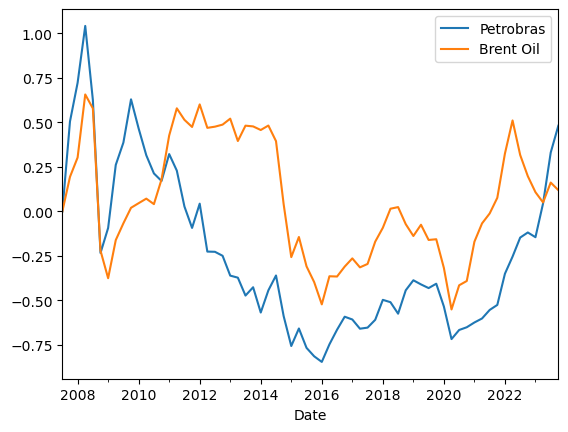

In [4]:
retorno_acumulado = dados/dados.iloc[0]-1
retorno_acumulado.plot()

### Retorno Aritmético

<Axes: xlabel='Date'>

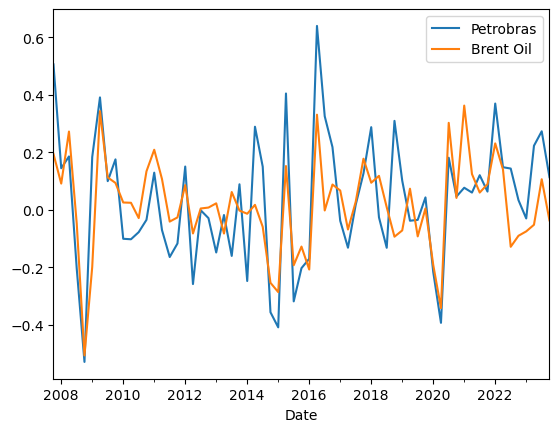

In [5]:
retorno_aritmetico = (dados/dados.shift(1)-1).dropna()
retorno_aritmetico.plot()

### Transformação logaritimica

A transformação logarítimica permite transformar séries temporais não-estacionárias em séries estacionárias, isso é importante para posteriormente poder inferir os parâmetros do modelo de regressão de forma adequada. 

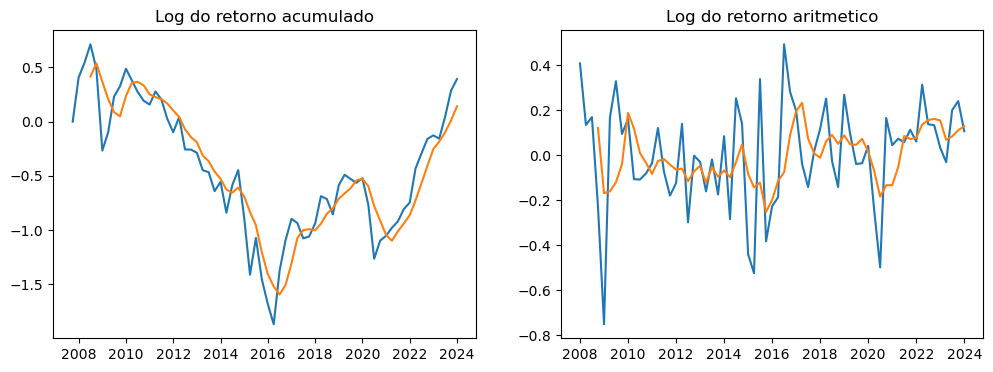

In [6]:
log_retorno_acumulado = np.log(dados/dados.iloc[0]).dropna()
log_retorno_aritmetico = (np.log(dados/dados.shift(1))).dropna()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Log do retorno acumulado")
plt.plot(log_retorno_acumulado['Petrobras'])
plt.plot(log_retorno_acumulado['Petrobras'].rolling(4).mean()) #Média Móvel de 4 trimestres

plt.subplot(1,2,2)
plt.title("Log do retorno aritmetico")
plt.plot(log_retorno_aritmetico['Petrobras'])
plt.plot(log_retorno_aritmetico['Petrobras'].rolling(4).mean()) #Média Móvel de 4 trimestres

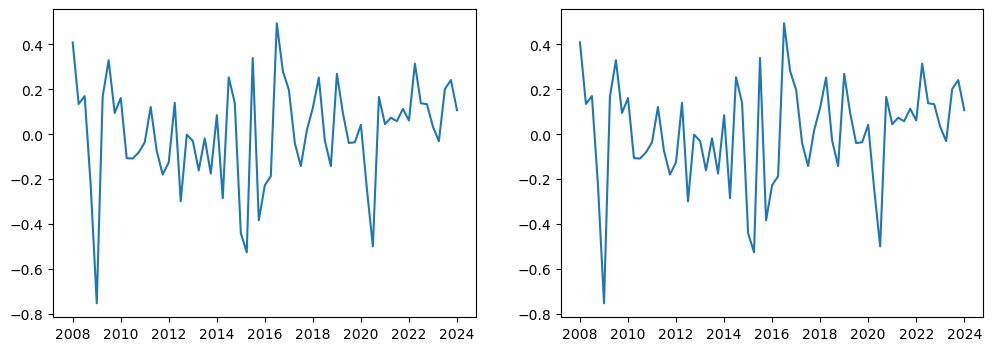

In [7]:
# Outra propriedade é que o log do retorno aritmético é igual a ln(preço) - ln(preço t-1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(log_retorno_aritmetico['Petrobras'])

plt.subplot(1,2,2)
plt.plot(np.log(dados['Petrobras']) - np.log(dados['Petrobras'].shift(1)))

### Distribuição dos Dados

O gráfico de dispersão (scatter plot) fornece insights preliminares sobre a relação estatística entre as variáveis observadas.

In [8]:
#Cálculo da correlação

correlacao = log_retorno_aritmetico['Petrobras'].corr(log_retorno_aritmetico['Brent Oil'])
round(correlacao,3)

0.745

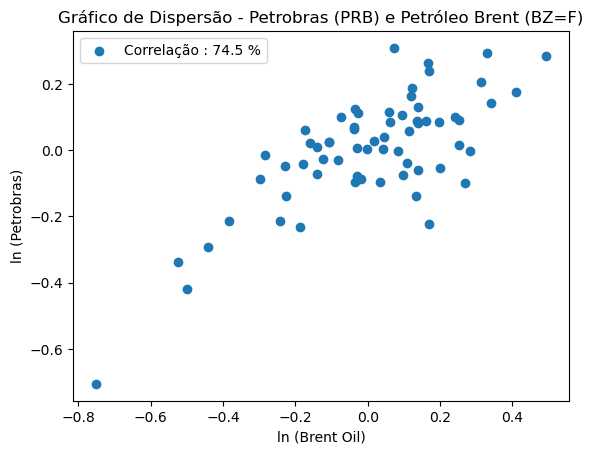

In [9]:
#Gráfico de Dispersão ou Scatter Plot

plt.scatter(log_retorno_aritmetico['Petrobras'], log_retorno_aritmetico['Brent Oil'], 
            label = f"Correlação : {round(correlacao*100,1)} %")
plt.xlabel('ln (Brent Oil)')
plt.ylabel('ln (Petrobras)')
plt.title('Gráfico de Dispersão - Petrobras (PRB) e Petróleo Brent (BZ=F)')
plt.legend()

# Regressão Linear Simples

A análise de regressão é uma técnica estatística que busca estudar a relação de dependência entre uma variável a ser explicada (dependente) e uma ou mais variáveis explanatórias (independentes). A função de regressão da população (FRP) pode ser representado conforme a função abaixo: 

$
Y_i = \beta_0 + \beta_1 X_i + u_i \\
$ 

$
Y_i = \text{Variável dependente} \\[1pt]
X_i = \text{Variável independente} \\[1pt]
\beta_0 = \text{Constante ou intercepto} \\[1pt]
\beta_1 = \text{Coeficiente angular} \\[1pt]
u_i = \text{Erro}
$

O método utilizado para estimar a função de regressão da amostra (FRA) é o Método dos Mínimos Quadrados (MQQ) que busca estimar os valores de $\hat{Y}_i$ que minimizem $\sum_{} \hat{u}_i^2$. Isso será explicado melhor em diante. 

### Preparando os cálculos

In [10]:
#Estamos atribuindo à variável df a tabela de log retornos, df é o nome genérico para dataframe

df = log_retorno_aritmetico

# Atribuíndo qual variável será a dependente (explicada) e a independente (explicativa)

y = df['Petrobras']
x = df['Brent Oil']

df

,Petrobras,Brent Oil
Date,,
2007-12-31,0.408988,0.177417
2008-03-31,0.134932,0.087130
2008-06-30,0.170115,0.240524
2008-09-30,-0.227844,-0.048312
2008-12-31,-0.752106,-0.705654
...,...,...
2022-12-31,0.033036,-0.094616
2023-03-31,-0.030595,-0.077954
2023-06-30,0.200989,-0.053440


### Método dos Mínimos Quadrados

Nós temos o problema de minimizar $\sum_{} \hat{u}_i$ que é igual a diferença dos valores efetivamente observados e dos valores estimados da nossa variável dependente: $\sum_{} (Y_i - \hat{Y}_i)$. Entretanto, essa minimização não leva em consideração a dispersão dos erros, é possível ter uma mesma soma de erros com amplitudes diferentes, a solução é elevar ao quadrado os resíduos e somar os resultados de tal modo que o conjunto de resíduos com valores mais dispersos terão um somatório maior e menos disperso menor. 

O problema então pode ser representado como: 

$min \sum_{} \hat{u}_i^2 = \sum_{} (Y_i - \hat{Y}_i)^2$.

Considerando que a FRA é igual a $\hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i$, podemos substituir $\sum_{} \hat{u}_i^2 = \sum_{} (Y_i - \hat{Y}_i)^2$ por $\sum_{} \hat{u}_i^2 = \sum_{} (Y_i - \color{red}{\hat{\beta}_0 - \hat{\beta}_1 X_i})^2$. Derivando em função de $\hat{\beta}_i$ e igualando a zero, para uma regressão linear simples temos as seguintes fórmulas para os parâmetros: 

$\large \frac{\partial (\sum_{} \hat{u}_i^2)}{\partial \hat{\beta}_0}$ $= - 2 \sum_{} (Y_i - \hat{\beta}_0 - \hat{\beta}_1 X_i) = -2\sum_{} \hat{u}_i = 0$

$\large \frac{\partial (\sum_{} \hat{u}_i^2)}{\partial \hat{\beta}_1}$ $= - 2 \sum_{} (Y_i - \hat{\beta}_0 - \hat{\beta}_1 X_i) X_i = -2\sum_{} \hat{u}_i X_i = 0$


Peguemos o parâmetro $\hat{\beta}_0$:

$
\sum_{} (Y_i - \hat{\beta}_0 - \hat{\beta}_1 X_i) = 0\\
\sum_{} Y_i  - \sum_{} \hat{\beta}_0  - \sum_{} \hat{\beta}_1 X_i   = 0\\
n \hat{\beta}_0 = n \bar{Y_i}  - n \beta_i \bar{X_i}\\
\hat{\beta}_0 = \bar{Y_i}  - \beta_i \bar{X_i}\\
$

Peguemos o parâmetro $\hat{\beta}_1$ e substituímos $\hat{\beta}_0$:

$
\sum_{} (Y_i - \hat{\beta}_0 - \hat{\beta}_1 X_i) X_i = 0\\
\sum_{} Y_i X_i -  (\color{red}{\bar{Y_i}  - \beta_i \bar{X_i}}) \sum_{}  X_i -  \hat{\beta}_1 \sum_{} X_i^2  = 0\\
\sum_{} Y_i X_i - \bar{Y_i}\sum_{}  X_i  + \beta_i \bar{X_i} \sum_{}  X_i  -  \hat{\beta}_1 \sum_{} X_i^2  = 0\\
\sum_{} Y_i X_i - n \bar{Y_i} \bar{X_i}  + n \beta_i \bar{X_i} \bar{X_i}  -  \hat{\beta}_1 \sum_{} X_i^2  = 0\\
\sum_{} Y_i X_i - n \bar{Y_i} \bar{X_i} = \hat{\beta}_1 \sum_{} X_i^2 - n \hat{\beta}_i \bar{X_i} \bar{X_i}\\
\sum_{} Y_i X_i - n \bar{Y_i} \bar{X_i} = \hat{\beta}_1 (\sum_{} X_i^2 - n \bar{X_i}^2)\\
\hat{\beta}_1 = \large \frac{\sum_{} Y_i X_i - n \bar{Y_i} \bar{X_i}}{\sum_{} X_i^2 - n \bar{X_i}^2}\\
$

Link: https://are.berkeley.edu/courses/EEP118/current/section/derivation.pdf

### Coeficiente Angular

Formula para o cálculo da constante:

$
\hat{\beta}_1 = \large \frac{\sum_{} Y_i X_i - n \bar{Y_i} \bar{X_i}}{\sum_{} X_i^2 - n \bar{X_i}^2}
$

In [11]:
b = (sum(y*x) - len(y)*y.mean()*x.mean()) / (sum(x**2)-len(x)*x.mean()**2) 
b

1.0070314959791

### Constante

Formula para o cálculo da constante.

$
\hat{\beta}_0 = \bar{Y} - \hat{\beta}_1 \cdot \bar{X} \
$

In [12]:
a = y.mean() - b*x.mean()
a

0.004298641055466552

### Abordagem Matricial

A abordagem matricial é proveitosa e muito indicada quando trabalha-se com modelos de regressão linear múltipla:

$\beta = (X^TX)^{-1}X^TY$

Link: https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf

Link_2: https://online.stat.psu.edu/stat462/node/132/

In [13]:
Y_matrix = y.values
X_matrix = np.column_stack((np.ones_like(x.values), x.values))

beta = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ y

# Imprimir os coeficientes encontrados
print("Intercepto:", round(beta[0],3))
print("Coeficiente Angular:", round(beta[1],3))

Intercepto: 0.004
Coeficiente Angular: 1.007


### Previsão

Visto que já encontramos a nossa constante $\hat{\beta}_0$ e o coeficiente angular $\hat{\beta}_1$, podemos estimar os valores de $\hat{Y_i}$ associado a cada valor observado de $X_i$ segundo o modelo de regressão que construímos. O ideal é que estejam o mais próximo possível dos valores efetivamente observados de $Y_i$.

$\hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i$

In [14]:
#Cálculo da previsão

df['Previsto'] = a + b * x
df[['Petrobras','Previsto']]

,Petrobras,Previsto
Date,,
2007-12-31,0.408988,0.182963
2008-03-31,0.134932,0.092041
2008-06-30,0.170115,0.246514
2008-09-30,-0.227844,-0.044353
2008-12-31,-0.752106,-0.706317
...,...,...
2022-12-31,0.033036,-0.090982
2023-03-31,-0.030595,-0.074203
2023-06-30,0.200989,-0.049517


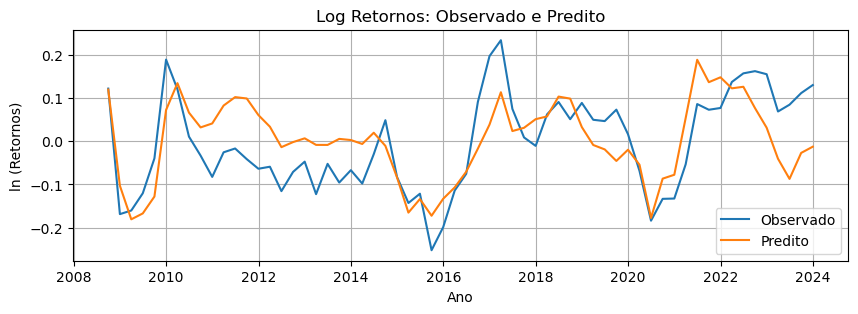

In [15]:
#Gráfico suavizado para médias móveis de 4 trimestres (1 ano)

plt.figure(figsize=(10,3))

plt.plot(y.rolling(4).mean(), label = 'Observado')
plt.plot(df['Previsto'].rolling(4).mean(), label = 'Predito')
plt.title("Log Retornos: Observado e Predito")
plt.xlabel('Ano')
plt.ylabel('ln (Retornos)')
plt.legend()
plt.grid()
plt.show()

### Resíduos

O erro $u_i$ é simplesmente a diferença do valor previsto $\hat{Y_i}$ em relação aos valores efetivamente observados de $Y_i$, representa os resíduos que não são explicados pelo modelo de regressão. A ideia de utilizar o MQQ (Mínimos Quadrados Quadrados) é encontrar a FRA (Função de Regressão Amostral) que minimize $\sum_{} \hat{u}_i^2$. Matematicamente pode ser expresso da seguinte forma: 

$\hat{u}_i = Y_i - \hat{Y_i}$

No Estatística Básica do Bussab e Morettin (2005) sugere-se plotar em um gráfico de dispersão e no gráfico Q-Q os resíduos em relação a variável explicativo para visualizar se respeitam a hipótese de normalidade. A hipótese de normalidade é importante pois implica que os parâmetros também são normalmente distribuídos. 

In [16]:
#Cálculo dos resíduos

df['Residuos'] = y - df['Previsto']
df['Residuos']

Date
2007-12-31    0.226025
2008-03-31    0.042891
2008-06-30   -0.076399
2008-09-30   -0.183491
2008-12-31   -0.045789
                ...   
2022-12-31    0.124018
2023-03-31    0.043608
2023-06-30    0.250506
2023-09-30    0.135208
2023-12-31    0.140649
Freq: Q-DEC, Name: Residuos, Length: 65, dtype: float64

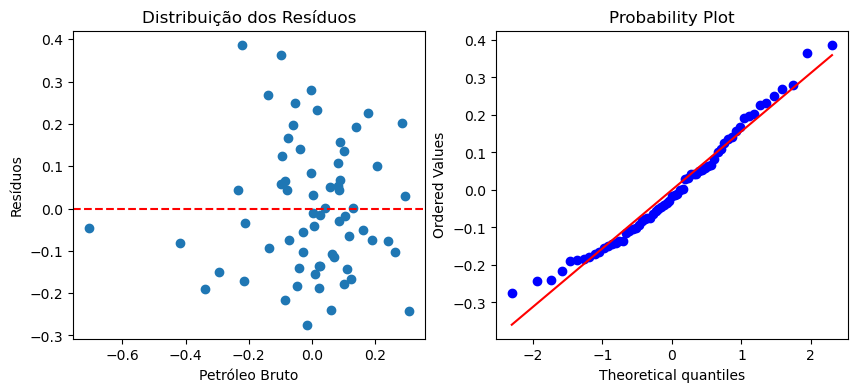

In [17]:
#Gráfico de Dispersão dos Resíduos

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(x, df['Residuos'])
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Petróleo Bruto')
plt.ylabel('Resíduos')
plt.title('Distribuição dos Resíduos')

#Gráfico Q-Q
plt.subplot(1,2,2)
stats.probplot(df['Residuos'], dist="norm", fit =True, plot=pylab);

Uma das hipóteses do modelo de regressão linear é que não há correlação entre $X_i$ e $u_i$, ou seja, devem ser próximos ou iguais a zero e a média $\bar{u_i}$ do erro também deve ser igual ou próximo de zero. 

In [18]:
media_erro = df['Residuos'].mean()
correlacao_residuos = df['Residuos'].corr(x)

#Pode-se verificar que os valores são extremamente baixos.

print(media_erro)
print(correlacao_residuos)

-5.124106267500723e-18
-4.0754028384342757e-16


### Coeficiente de Determinação - R2

É uma medida estatística que mede o quanto a função de regressão se ajusta aos valores observados da variável dependente observada $Y_i$. Um caso hipotético seria onde todos os valores estimados da variável dependente fossem iguais aos valores observados ($Y_i = \hat{Y}_i$), neste caso não haveria resíduos ($SQRes= 0$) e o coeficiente de determinação $R^2$ seria igual a 1 ou 100%. 

$
R^2 = 1 - \large \frac{SQRes}{SQReg}
$

In [19]:
#Soma dos Quadrados Totais
SQReg = sum((y-y.mean())**2)

#Soma dos Quadrados dos Resíduos
SQRes = sum(df['Residuos']**2)

#Cálculo do Coeficiente de Determinação
r2 = 1 - SQRes/SQReg
r2

0.5554910919385063

# Problemas de Inferência

A inferência estatística é o campo na estatística que estuda como é possível a partir de uma amostra (parte) inferir algo sobre a população (todo). A inferência se faz necessária pois muitas vezes é impossível ou muito custoso coletar informação sobre toda a população enquanto é possível dado uma amostra suficiente boa inferir com confiança algo da população, um exemplo típico são as pesquisas eleitorais.

Uma vez obtida uma amostra, podemos a partir dela gerar informações tais como sua média, desvio-padrão ou no caso de um modelo de regressão estimar os parâmetros de uma função de regressão amostral (FRA). Na nossa função de regressão encontramos valores pontuais para os nossos parâmetros estimados ($\hat{\beta}_1 = 1,007$), entretanto não leva em consideração o possível erro desta estimação, ou seja, o parâmetro estimado pode ser diferente do valor pontual encontrado. A forma para encontrar essa "margem de erro" é por meio do intervalo de confiança:

### Intervalo de Confiança

O intervalo de confiança representa os limites de valores que contém os coeficiente estimado $\hat{\beta}_i$ sob um nível de significância ($\alpha$) onde espera-se que ($1 - \alpha$) dos valores do coeficiente estariam distribuídos dentro deste limite. Para ilustar considere os retornos de um ativo com média $\bar{x} = 0$ e desvio-padrão $\sigma = 1$, no limite espera-se que com 95% de confiança a média $\bar{x} = 0$ esteja entre mais ou menos -2 e 2 desvios-padrões ($\sigma$) assumindo que os dados estejam normalmente distribuídos. 

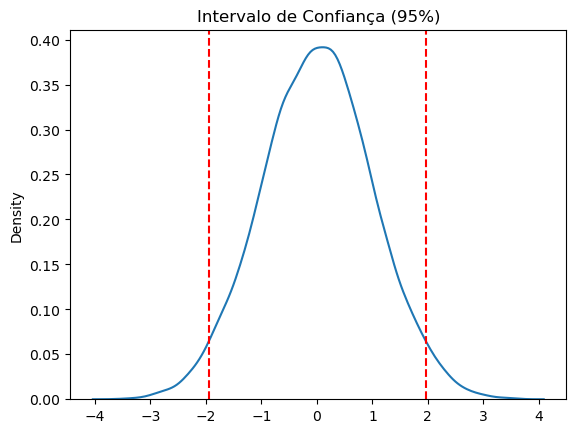

In [20]:
from scipy.stats import norm
import seaborn as sns

# Média e desvio-padrão
mu, sigma = 0, 1
simulacao = np.random.normal(mu, sigma, 10000)

# Intervalo de confiança
nivel_significância = 0.05
ic_simulacao  = norm.interval(1 - nivel_significância, loc=np.mean(simulacao), scale=np.std(simulacao))

# Gráfico kde
sns.kdeplot(simulacao)

# Gráfico intervalos de confiança
plt.title('Intervalo de Confiança (95%)')
plt.axvline(ic_simulacao[0], color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(ic_simulacao[1], color='red', linestyle='dashed', linewidth=1.5)

### Erro Padrão do Estimador

O erro padrão ($ep$) dos estimadores é utilizado para medir a sua confiabilidade, quanto menor o erro padrão ($ep$) menor será a probabilidade de ter obtido um estimador diferente dos coeficientes verdadeiros da população. O calculo dos estimadores segue a fórmula abaixo: 

$ ep(\hat{\beta}_1) = \large \sqrt{\frac{\sum_{i=1}^{n} \varepsilon_i^2}{(n-2) \sum_{i=1}^{n} (x_i - \bar{x})^2}} $

$ ep(\hat{\beta}_0) = ep(\hat{\beta}_1) \cdot \large \sqrt{\frac{\sum_{i=1}^{n} x_i^2}{n}}$

In [21]:
#Calculo do erro padrão do resíduo

s = (sum(df['Residuos']**2) / (len(df)-2))**0.5
s

0.15569293494207206

In [22]:
#Calculo do erro padrão do coeficiente angular

sb = s / (sum((x-x.mean())**2))**0.5
sb

0.11349440804120593

In [23]:
#Calculo do erro padrão da constante

sa = sb * (sum(x**2)/len(df))**(0.5)
sa

0.019312337684648555

### Intervalo de Confiança dos Estimadores

Com os erros padrões calculados, o intervalo de confiança para uma distribuição do tipo $t$ de student pode ser calculado como: 

$
\text{Intervalo de Confiança} = \hat{\beta_i} \pm t_{\alpha / 2} \cdot {ep(\hat{\beta_i})} \\
$

$ 
\hat{\beta_i} = \text{Coeficiente estimado} \\
t_{\alpha / 2} = \text{t crítico para um nível de significância }\alpha\\
ep = \text{Desvio (erro) padrão do estimador}
$

In [24]:
#Cálculo do Intervalo de Confiança

from scipy.stats import t

# Graus de Liberdade
num_coef = 2
tamanho_amostra = len(df)
graus_de_liberdade = tamanho_amostra - num_coef
media = 0

# Nível de significância escolhido
nivel_significancia = 0.05

# Calculo do intervalo do t crítico considerando uma distribuição t de student
t_critico = t.ppf(1 - nivel_significancia/2, graus_de_liberdade)

# Calculo do intervalo de confiança
ic_inferior = b - b * t_critico * sb
ic_superior = b + b * t_critico * sb

print(f"Limite Inferior: {round(ic_inferior,3)} \nLimite Superior: {round(ic_superior,3)}")
print(f"Nível de Significância: {nivel_significancia}")

Limite Inferior: 0.779 
Limite Superior: 1.235
Nível de Significância: 0.05


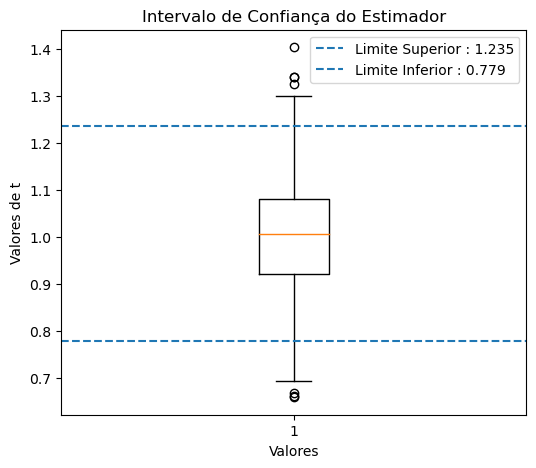

In [25]:
# Boxplot do intervalo de confiança

dados_t1 = t.rvs(df=graus_de_liberdade, loc=b, scale=sb, size=1000)

plt.figure(figsize=(6,5))
plt.boxplot(dados_t1)
plt.title('Intervalo de Confiança do Estimador')
plt.ylabel('Valores de t')
plt.xlabel('Valores')
plt.axhline(ic_superior, linestyle='--', label =f'Limite Superior : {round(ic_superior,3)}')
plt.axhline(ic_inferior, linestyle='--', label =f'Limite Inferior : {round(ic_inferior,3)}')
plt.legend();

### Teste T

O teste t é um teste estatístico utilizado quando a variância da população é desconhecida, a distribuição $t$ de student tende a ter caudas um pouco mais "gordas" do que a distribuição normal. Calcula-se o teste t para os coeficientes estimados ($\hat{\beta}_i$) que serão posteriormente utilizados nos testes de hipóteses:

$
t = \large \frac {\hat{\beta_i}}{ep(\hat{\beta_i})}\\[10pt]
$

$ 
\hat{\beta}_i = \text{Coeficiente estimado} \\[0pt]
ep(\hat{\beta}_i) = \text{Erro) padrão do estimador}
$

Associado ao teste t encontrado, há uma probabilidade de obter este valor em uma distribuição do tipo $t$ de student com $n$ graus de liberdade.

### Teste de Hipótese

Segundo Gujarati, na linguagem dos testes de significância, uma estatística é dita significativa se o valor do teste estatístico situar-se na região crítica, neste caso, a hipótese nula é rejeitada. Ao calcular o teste t, verifica-se se ele se encontra dentro ou fora do intervalo de confiança, caso ele esteja fora do intervalo então podemos rejeitar a hipótese nula $H_0$ de que o estimador é igual a zero e aceitar a hipótese alternativa $H_1$ de que ele é diferente de zero. 

$
H_0: \hat{\beta}_1 = 0 \\
H_1: \hat{\beta}_1 \neq 0
$

Uma hipótese muito importante de ser testada é que $ H_0: \hat{\beta}_i = 0 $, caso rejeite esta hipótese nula então pode-se afirmar que o coeficiente estimado tem alguma relação significativa com a variável dependente $Y_i$. A forma de fazer isso é relativamente simples, ao calcular o teste t, verifica-se o valor encontrado dentro de uma distribuição $t$ de student com $n$ graus de liberdade, caso a probabilidade de obter este valor seja menor que o nível de significância escolhido, então rejeita-se a hipótese nula. 

Distribuição t de Student: https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_t_de_Student 

Teste t de Student: https://pt.wikipedia.org/wiki/Teste_t_de_Student

In [26]:
t_angular = b/sb
t_constante = a/sa


print(t_angular)
print(t_constante)

8.872961349897357
0.22258522638010605


In [27]:
# O cálculo da probabilidade dos testes t podem ser calculadas conforme funções abaixo: 

p_value_angular = stats.t.sf(t_angular, graus_de_liberdade)*2
p_value_constante = stats.t.sf(t_constante, graus_de_liberdade)*2

print(f"A probabilidade de obter de obter um valor t de {round(t_angular,3)} é de {p_value_angular}.")
print(f"A probabilidade de obter de obter um valor t de {round(t_constante,3)} é de {p_value_constante}.")

A probabilidade de obter de obter um valor t de 8.873 é de 1.0745989766320188e-12.
A probabilidade de obter de obter um valor t de 0.223 é de 0.8245783936430303.


### Teste F

Outro teste que pode ser feito é o teste F que permite avaliar se o modelo de regressão é significativo globalmente. Ele compara a variança explicada pelo modelo (SQreg) com a não explicada pelo modelo (SQRes) e associa um valor-p ao resultado.

$F = \large \frac{SQReg - SQRes}{SQRes / (n - p - 1)}$

$
SQReg = \text{Soma do Quadrado da Regressão} \\
SQRes = \text{Soma do Quadrado dos Resíduos} \\
p = \text{Número de parâmetros} \\
n = \text{Número de observações} \\
$

In [28]:
F = (SQReg-SQRes)/(SQRes/(tamanho_amostra-2))
F

78.72944311677222

In [29]:
p_value_f = stats.f.sf(F, 1, graus_de_liberdade)
print(f"A probabilidade de obter de obter um valor f de {round(F,2)} é de {p_value_f}")

A probabilidade de obter de obter um valor f de 78.73 é de 1.0745989766320468e-12


## Resultado Final

In [30]:
df

,Petrobras,Brent Oil,Previsto,Residuos
Date,,,,
2007-12-31,0.408988,0.177417,0.182963,0.226025
2008-03-31,0.134932,0.087130,0.092041,0.042891
2008-06-30,0.170115,0.240524,0.246514,-0.076399
2008-09-30,-0.227844,-0.048312,-0.044353,-0.183491
2008-12-31,-0.752106,-0.705654,-0.706317,-0.045789
...,...,...,...,...
2022-12-31,0.033036,-0.094616,-0.090982,0.124018
2023-03-31,-0.030595,-0.077954,-0.074203,0.043608
2023-06-30,0.200989,-0.053440,-0.049517,0.250506


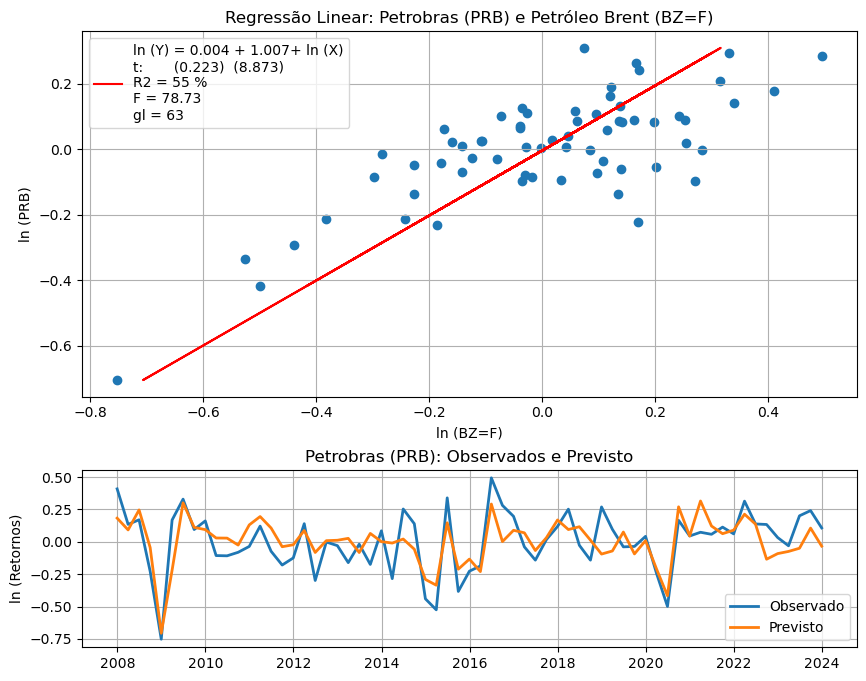

In [31]:
fig = plt.figure(figsize=(10,8))

gs = fig.add_gridspec(nrows = 10, ncols = 1)

ax1 = fig.add_subplot(gs[0:6, 0])
ax2 = fig.add_subplot(gs[7:10, 0])

#Gráfico da Regressão
ax1.set_title('Regressão Linear: Petrobras (PRB) e Petróleo Brent (BZ=F)')
ax1.scatter(y, x)
ax1.plot(df['Previsto'], x, color = 'red', 
         label = f"ln (Y) = {round(a,3)} + {round(b,3)}+ ln (X)"+
         f"\nt:       ({round(t_constante,3)})  ({round(t_angular,4)})"+
         f"\nR2 = {int(r2*100)} %\nF = {round(F,2)}\ngl = {graus_de_liberdade}")
ax1.set_ylabel('ln (PRB)')
ax1.set_xlabel('ln (BZ=F)')
ax1.grid(True)
ax1.legend()

#Gráfico da Previsão
ax2.set_title('Petrobras (PRB): Observados e Previsto')
ax2.plot(y, label = 'Observado', linewidth=2)
ax2.plot(df['Previsto'], label = 'Previsto', linewidth=2)
ax2.set_ylabel('ln (Retornos)')
ax2.grid(True)
ax2.legend()

### Validação dos Dados com Statsmodels

Podemos agora comparar os resultados calculados manualmente com que obteríamos utilizando uma biblioteca como a statmodels.

In [32]:
X = sm.add_constant(x)
modelo = sm.OLS(y, X)
resultados = modelo.fit()
resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Petrobras   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     78.73
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           1.07e-12
Time:                        16:21:53   Log-Likelihood:                 29.676
No. Observations:                  65   AIC:                            -55.35
Df Residuals:                      63   BIC:                            -51.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.019      0.223      0.825      -0.034       0.043
Brent Oil      1.0070      0.113      8.873      0.000       0.780       1.234
==============================================================================
Omnibus:                        2.976   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.893
Skew:                           0.470   Prob(JB):                        0.235
Kurtosis:                       2.572   Cond. No.                         5.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""